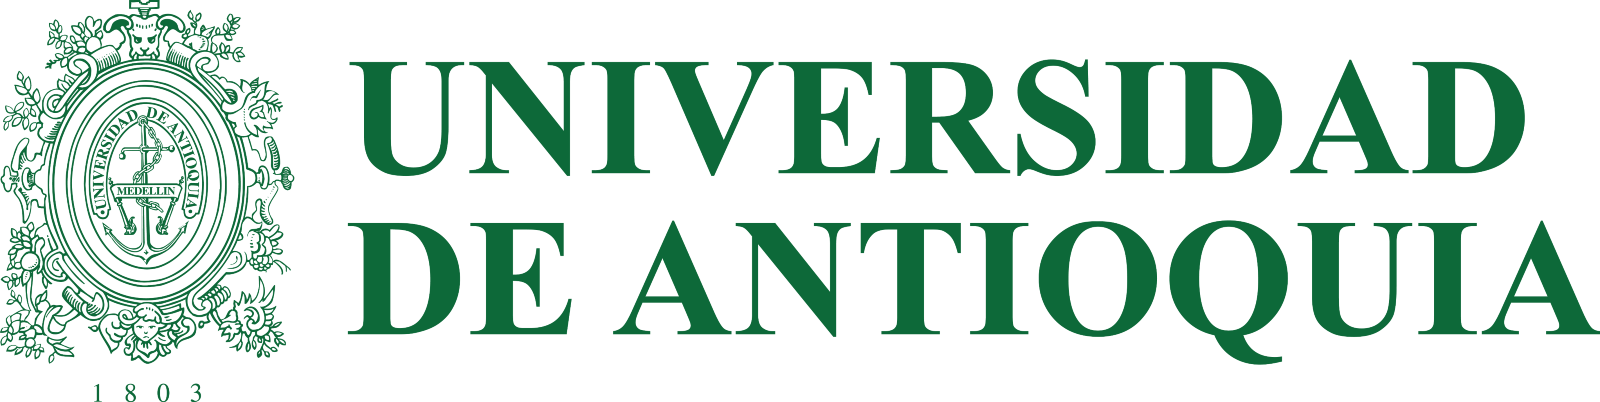

# 04 - Entrenamiento y Evaluación del Modelo Base

**Proyecto:** Análisis de Sentimiento utilizando LSTM
**Autores:** Daniel Brand Taborda, Jhonier Raúl Jiménez
**Curso:** Deep Learning 2025 - Universidad de Antioquia

## Introducción

Este notebook se centra en el entrenamiento del modelo BiLSTM base definido en el notebook anterior y en su evaluación exhaustiva utilizando el conjunto de prueba.

Los pasos clave son:
1.  **Carga de Datos y Tokenizer:** Cargar los datos preprocesados (entrenamiento y prueba) y el tokenizer ajustado.
2.  **Preparación Final de Datos:** Aplicar tokenización y padding a los datos cargados.
3.  **Definición y Compilación del Modelo:** Re-definir y compilar la arquitectura del modelo para asegurar consistencia.
4.  **Entrenamiento:** Entrenar el modelo usando los datos de entrenamiento y monitorear el rendimiento en un conjunto de validación.
5.  **Guardado del Modelo Entrenado:** Guardar el modelo final con sus pesos aprendidos.
6.  **Visualización del Entrenamiento:** Graficar las curvas de pérdida y exactitud (accuracy) durante el entrenamiento.
7.  **Evaluación en Test:** Evaluar el rendimiento del modelo final sobre el conjunto de prueba (datos nunca vistos durante el entrenamiento).
8.  **Análisis de Métricas:** Calcular y mostrar métricas detalladas (Accuracy, Precision, Recall, F1-Score) y la Matriz de Confusión.
9.  **(Opcional) Análisis de Errores:** Revisar algunos ejemplos mal clasificados.

In [5]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Librerías importadas.")

2025-05-01 16:38:29.020201: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 16:38:29.021890: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 16:38:29.042920: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 16:38:29.057114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746135509.079304   74742 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746135509.08

Librerías importadas.


## 1. Carga de Datos Preprocesados y Tokenizer

Cargamos los datos de entrenamiento y prueba (`train_processed.csv`, `test_processed.csv`) generados por el notebook `02 - preprocesado.ipynb`. También cargamos el `tokenizer` que fue ajustado y guardado en el notebook `03 - tokenizacion_y_modelo_base.ipynb`.

In [15]:
# --- Rutas ---
input_dir = 'processed_data'
train_path = os.path.join(input_dir, 'train_processed.csv')
test_path = os.path.join(input_dir, 'test_processed.csv')
tokenizer_path = 'tokenizer_config.json'

# --- Cargar Datos ---
try:
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    train_sentences = train_df['review'].fillna('').astype(str).tolist()
    train_labels = train_df['sentiment'].values
    test_sentences = test_df['review'].fillna('').astype(str).tolist()
    test_labels = test_df['sentiment'].values

    print("Datos preprocesados cargados.")
    print(f"  - Muestras de Entrenamiento: {len(train_sentences)}")
    print(f"  - Muestras de Prueba:      {len(test_sentences)}")

except FileNotFoundError:
    print(f"Error: No se encontraron los archivos CSV en '{input_dir}'. Ejecuta el Notebook 02.")
    # Detener o manejar
    train_sentences, test_sentences, train_labels, test_labels = [], [], [], []
except Exception as e:
     print(f"Ocurrió un error al cargar los datos CSV: {e}")
     train_sentences, test_sentences, train_labels, test_labels = [], [], [], []

# --- Cargar Tokenizer ---
try:
    with open(tokenizer_path, 'r', encoding='utf-8') as f:
        tokenizer_json_str = json.load(f) # Carga la cadena JSON externa
        tokenizer = tokenizer_from_json(tokenizer_json_str) # Parsea la cadena interna
    print("Tokenizer cargado exitosamente.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo del tokenizer en: {tokenizer_path}. Ejecuta el Notebook 03.")
    tokenizer = None
except Exception as e:
    print(f"Ocurrió un error al cargar el tokenizer: {e}")
    tokenizer = None

Datos preprocesados cargados.
  - Muestras de Entrenamiento: 37500
  - Muestras de Prueba:      12500
Tokenizer cargado exitosamente.


## 2. Preparación Final de Datos (Tokenización y Padding)

Aunque el tokenizer ya está ajustado, necesitamos usarlo para convertir nuestros textos cargados en secuencias numéricas y luego aplicar padding para asegurar una longitud uniforme, tal como se definió en el notebook anterior. Repetimos este paso aquí para asegurar que los datos de entrada al modelo sean correctos.

In [16]:
# --- Re-definir Hiperparámetros (para consistencia, deben ser los mismos del Notebook 3) ---
vocab_size = 3000     # Asegúrate que coincida con el usado al crear el tokenizer
oov_tok = "<OOV>"     # Asegúrate que coincida
max_length = 200      # Asegúrate que coincida
padding_type = 'post' # Asegúrate que coincida
trunc_type = 'post'   # Asegúrate que coincida

# --- Tokenizar y Padear ---
if tokenizer and train_sentences: # Si el tokenizer y los datos se cargaron
    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)

    train_padded = pad_sequences(train_sequences, maxlen=max_length,
                                padding=padding_type, truncating=trunc_type)
    test_padded = pad_sequences(test_sequences, maxlen=max_length,
                               padding=padding_type, truncating=trunc_type)

    # Convertir etiquetas a numpy array si no lo son ya
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)


    print("Tokenización y Padding completados.")
    print(f"  - Forma de train_padded: {train_padded.shape}")
    print(f"  - Forma de test_padded: {test_padded.shape}")
    print(f"  - Forma de train_labels: {train_labels.shape}")
    print(f"  - Forma de test_labels: {test_labels.shape}")
else:
    print("No se puede continuar sin datos o tokenizer.")
    # Detener ejecución o manejar
    train_padded, test_padded = np.array([]), np.array([])

Tokenización y Padding completados.
  - Forma de train_padded: (37500, 200)
  - Forma de test_padded: (12500, 200)
  - Forma de train_labels: (37500,)
  - Forma de test_labels: (12500,)


## 3. Definición y Compilación del Modelo

Re-definimos la arquitectura del modelo BiLSTM exactamente como en el notebook anterior para asegurar que estamos entrenando la estructura correcta. Luego, lo compilamos con la misma configuración.

In [17]:
# --- Re-definir Hiperparámetros del Modelo (Deben coincidir con Notebook 3) ---
embedding_dim = 100
lstm_units = 64
dense_units = 24

# --- Construcción del Modelo ---
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length),
    Bidirectional(LSTM(units=lstm_units)),
    Dense(units=dense_units, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

# --- Compilación ---
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("Modelo BiLSTM re-definido y compilado.")
model.summary() # Mostrar resumen para confirmar

Modelo BiLSTM re-definido y compilado.


/home/user/Documentos/udea/deep learning/model/setiment-analysis/.venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 100)       │       300,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         3,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,162,805 (4.44 MB)

 Trainable params: 387,601 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 775,204 (2.96 MB)

## 4. Entrenamiento del Modelo

Ahora entrenamos el modelo con los datos de entrenamiento (`train_padded`, `train_labels`). Utilizamos una fracción de estos datos (`validation_split`) para monitorear el rendimiento en datos no vistos durante el entrenamiento en cada época. Guardamos el historial del entrenamiento para análisis posterior.

In [19]:
# --- Hiperparámetros de Entrenamiento ---
num_epochs = 5       # Número de épocas (ajustar según sea necesario)
batch_size = 64      # Tamaño del lote (puede ajustarse)
validation_split = 0.1 # Usar 10% de los datos de entrenamiento para validación

print(f"Iniciando entrenamiento por {num_epochs} épocas...")

if train_padded.size > 0: # Asegurarse que hay datos
    history = model.fit(train_padded, train_labels,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        validation_split=validation_split,
                        verbose=1) # Muestra barra de progreso y métricas por época
    print("Entrenamiento completado.")
else:
    print("No hay datos para entrenar.")
    history = None

Iniciando entrenamiento por 5 épocas...
Epoch 1/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - accuracy: 0.8946 - loss: 0.2634 - val_accuracy: 0.8749 - val_loss: 0.3014
Epoch 2/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 47s 90ms/step - accuracy: 0.9056 - loss: 0.2334 - val_accuracy: 0.8541 - val_loss: 0.3225
Epoch 3/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 48s 91ms/step - accuracy: 0.9200 - loss: 0.2117 - val_accuracy: 0.8747 - val_loss: 0.3231
Epoch 4/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 48s 92ms/step - accuracy: 0.9294 - loss: 0.1864 - val_accuracy: 0.8659 - val_loss: 0.3338
Epoch 5/5
528/528 ━━━━━━━━━━━━━━━━━━━━ 50s 95ms/step - accuracy: 0.9382 - loss: 0.1674 - val_accuracy: 0.8683 - val_loss: 0.3682
Entrenamiento completado.


## 5. Guardar Modelo Entrenado

Guardamos el modelo entrenado completo (arquitectura, pesos y estado del optimizador) en un archivo `.h5`. Esto nos permite cargarlo directamente para hacer predicciones sin necesidad de reentrenar.

In [20]:
model_save_path = 'sentiment_model.h5'

if history is not None: # Solo guardar si el entrenamiento ocurrió
    try:
        model.save(model_save_path)
        print(f"Modelo entrenado guardado exitosamente en: {model_save_path}")
    except Exception as e:
        print(f"Error al guardar el modelo entrenado: {e}")
else:
    print("Modelo no entrenado, no se guardará.")

# Opcional: Cargar el modelo guardado para verificar (y usarlo para evaluación)
# print("Cargando modelo guardado para evaluación...")
# model = load_model(model_save_path)

Modelo entrenado guardado exitosamente en: sentiment_model.h5


## 6. Visualización del Historial de Entrenamiento

Graficamos las métricas de exactitud (accuracy) y pérdida (loss) tanto para el conjunto de entrenamiento como para el de validación a lo largo de las épocas. Esto nos ayuda a identificar si el modelo está aprendiendo correctamente y si hay signos de sobreajuste (overfitting) o subajuste (underfitting).

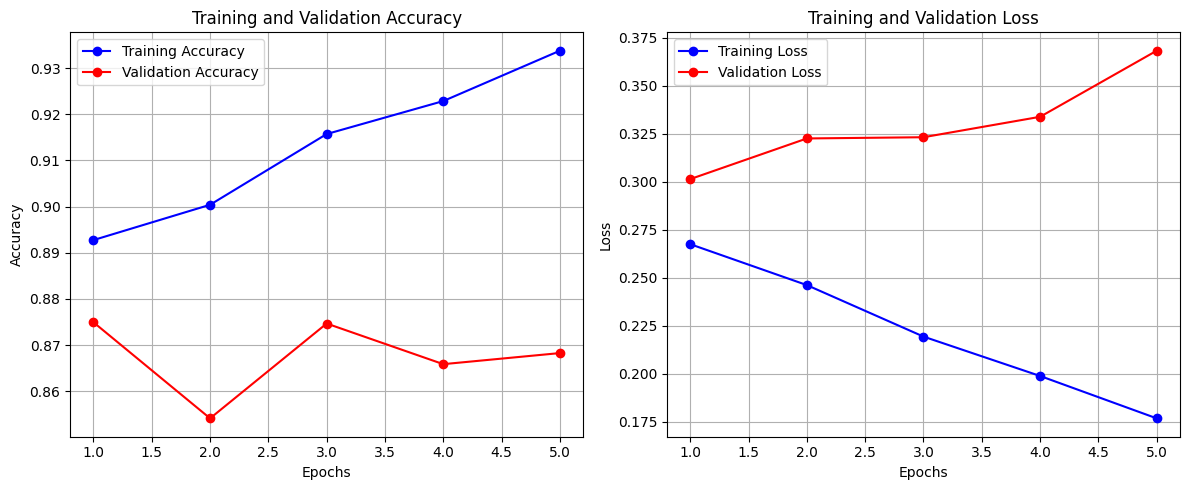

In [21]:
def plot_history(history):
    """Función para graficar accuracy y loss de entrenamiento y validación."""
    if history is None or not history.history:
        print("No hay historial de entrenamiento para graficar.")
        return

    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    if acc is None or val_acc is None or loss is None or val_loss is None:
        print("El historial no contiene todas las métricas necesarias (accuracy, val_accuracy, loss, val_loss).")
        print("Métricas disponibles:", list(history.history.keys()))
        return

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Gráfico de Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Gráfico de Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Llamar a la función para graficar
plot_history(history)

## 7. Evaluación en el Conjunto de Prueba

Realizamos la evaluación final del modelo utilizando el conjunto de prueba (`test_padded`, `test_labels`), que el modelo no ha visto durante el entrenamiento ni la validación intra-entrenamiento. Calculamos las predicciones y luego las métricas de desempeño clave que definimos en la Entrega 1.

In [22]:
if model and test_padded.size > 0: # Verificar que el modelo existe y hay datos de test
    print("Evaluando el modelo en el conjunto de prueba...")

    # Obtener probabilidades
    predictions_prob = model.predict(test_padded, batch_size=batch_size, verbose=1)

    # Convertir probabilidades a etiquetas binarias (0 o 1)
    predictions = (predictions_prob >= 0.5).astype(int).flatten() # flatten por si la salida es (None, 1)

    # Calcular Accuracy
    accuracy = accuracy_score(test_labels, predictions)
    print(f"\nAccuracy en el conjunto de prueba: {accuracy:.4f}")

    # Generar Reporte de Clasificación (Precision, Recall, F1-Score)
    print("\nReporte de Clasificación:")
    # Asegúrate de que encoder.classes_ exista o define las etiquetas manualmente
    target_names = ['Negative', 'Positive'] # Asumiendo 0=Negative, 1=Positive
    try:
         print(classification_report(test_labels, predictions, target_names=target_names))
    except Exception as e:
         print(f"Error al generar classification_report: {e}")
         # Intenta sin target_names si causa problemas
         # print(classification_report(test_labels, predictions))


    # Calcular Matriz de Confusión
    cm = confusion_matrix(test_labels, predictions)

else:
    print("No se puede evaluar, falta el modelo o los datos de prueba.")
    cm = None # Para evitar error en la siguiente celda

Evaluando el modelo en el conjunto de prueba...
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step

Accuracy en el conjunto de prueba: 0.8659

Reporte de Clasificación:
              precision    recall  f1-score   support

    Negative       0.85      0.89      0.87      6250
    Positive       0.88      0.84      0.86      6250

    accuracy                           0.87     12500
   macro avg       0.87      0.87      0.87     12500
weighted avg       0.87      0.87      0.87     12500



## 8. Visualización de la Matriz de Confusión

Visualizamos la matriz de confusión para entender mejor el rendimiento del clasificador. Nos muestra cuántas predicciones fueron correctas (diagonal principal: Verdaderos Positivos y Verdaderos Negativos) y cuántas fueron incorrectas (fuera de la diagonal: Falsos Positivos y Falsos Negativos) para cada clase.

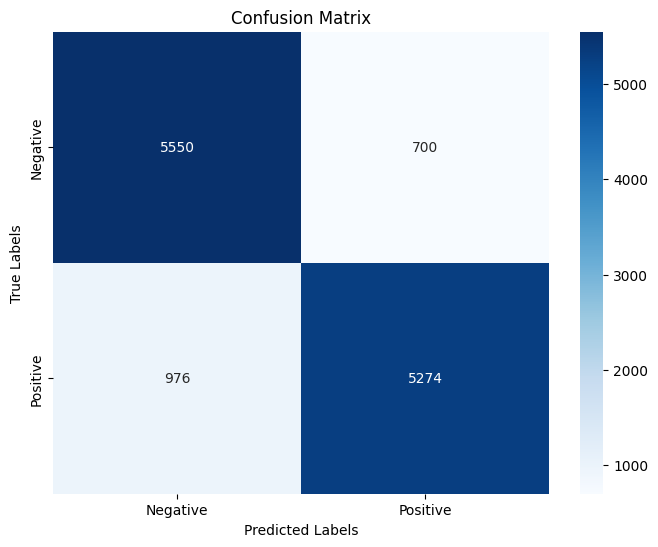

In [23]:
if cm is not None:
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
else:
    print("No se generó la matriz de confusión.")

## Conclusión de Entrenamiento y Evaluación

En este notebook, hemos entrenado nuestro modelo BiLSTM base durante `[5]` épocas. Las curvas de aprendizaje indican [describir brevemente: buen ajuste, sobreajuste ligero/temprano, etc.].

La evaluación final en el conjunto de prueba muestra un rendimiento de:
* **Accuracy:** `[0.8659]`
* **F1-Score (Promedio/Positivo/Negativo):** `[0.87, 0.86, 0.87]`

La matriz de confusión detalla [describir brevemente, ej. "buena distinción entre clases" o "tiende a confundir X con Y"].

El modelo entrenado ha sido guardado en `sentiment_model.h5` y está listo para ser utilizado para inferencia o para futuras comparaciones con modelos más avanzados.